In [25]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
doplot = true

true

## Packages for plotting

In [26]:
if doplot
    ccrs = pyimport("cartopy.crs")
    gridliner = pyimport("cartopy.mpl.gridliner")
    cfeature = pyimport("cartopy.feature")
    mticker = pyimport("matplotlib.ticker")
    myproj = ccrs.PlateCarree()
    coast = cfeature.GSHHSFeature(scale="full");
    mpl = pyimport("matplotlib");
    cartopyticker = pyimport("cartopy.mpl.ticker")
    lon_formatter = cartopyticker.LongitudeFormatter()
    lat_formatter = cartopyticker.LatitudeFormatter()
end 

PyObject <cartopy.mpl.ticker.LatitudeFormatter object at 0x7fe29b603d10>

## Files and directories

In [32]:
datadir = "./data/"
figdir = "./figures/"
datafile = joinpath(datadir, "Biddulphia_sinensis1995-2020.csv")
speciesname = "Biddulphia_sinensis"
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

┌ Info: File already downloaded
└ @ Main In[32]:7


## Data reading

In [28]:
dates, lons, lats, occurs = read_data_phyto(datafile);

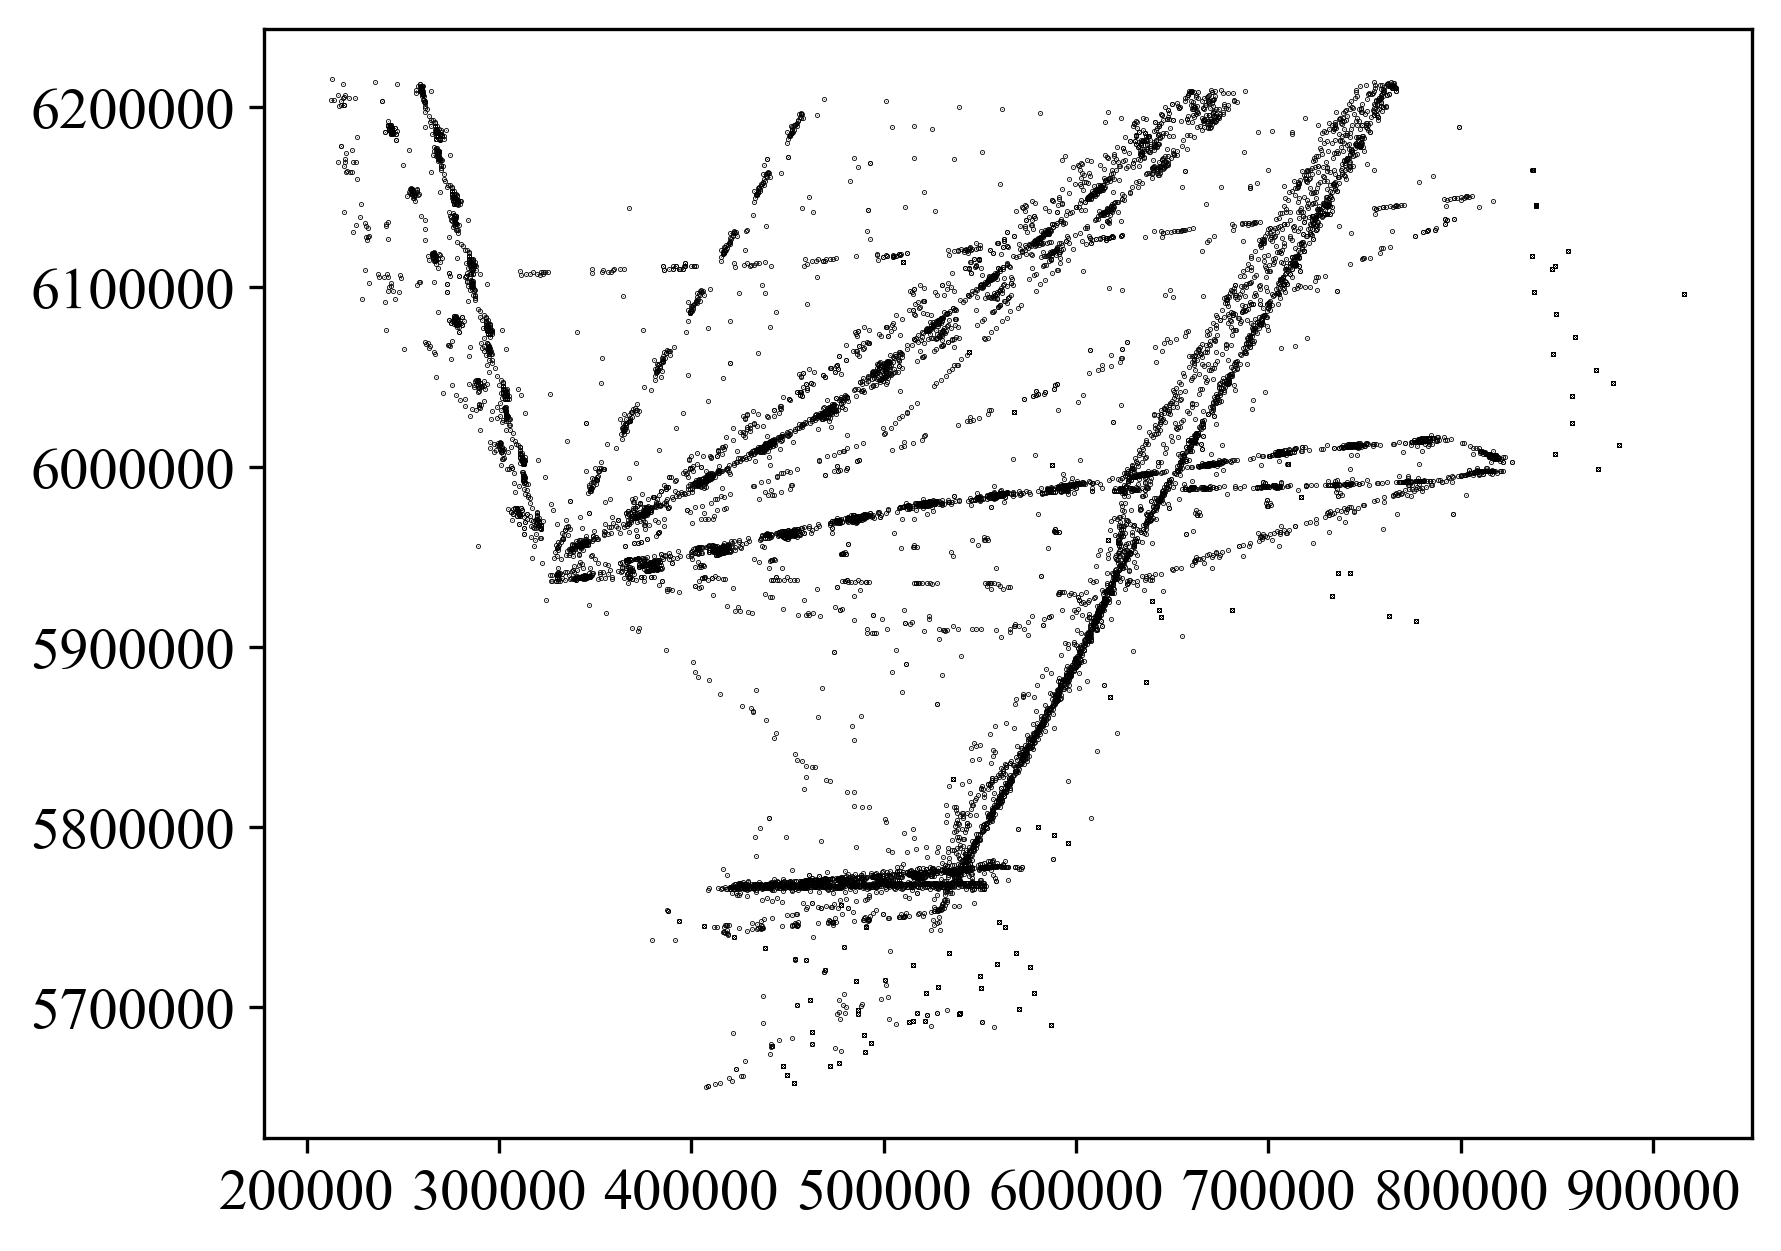

In [29]:
if doplot
    PyPlot.plot(lons, lats, "ko", markersize=0.2)
    PyPlot.show()
end

## Conversion of coordinates
We have to go from `EPSG:32361` to `WGS84`.     
We define these two projections and apply the `transform` function.

In [30]:
lon, lat = transform_coords(lons, lats);

In [34]:
if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111, projection=myproj)

    ax.plot(lon, lat, "ko", markersize=.2)
    decorate_map(ax)

    PyPlot.savefig(joinpath(figdir, "$(speciesname)_obs.png"), 
        dpi=300, bbox_inches="tight")
    PyPlot.close()
end

### Plot presence/absence

In [35]:
data_presence = occurs .== 1;
data_absence = .!(data_presence);

In [36]:
if doplot
    fig = PyPlot.figure(figsize=(8, 8))
    ax = PyPlot.subplot(211, projection=myproj)
    ax.plot(lon[data_presence], lat[data_presence], "ko", markersize=.2)
    title("Presence")
    decorate_map(ax)

    ax = PyPlot.subplot(212, projection=myproj)
    ax.plot(lon[data_absence], lat[data_absence], "ko", markersize=.2)
    title("Absence")
    decorate_map(ax)
    PyPlot.savefig(joinpath(figdir, "$(speciesname)_data_presence_absence.png"), 
        dpi=300, bbox_inches="tight")
    #PyPlot.show()
    PyPlot.close()
end

## Prepare mask
### Interpolation grid


In [37]:
longrid = -2.:0.1:10.
latgrid = 51.:0.1:56.

51.0:0.1:56.0

### Download file

In [38]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[38]:5


### Read bathymetry

In [39]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

size(b) = (121, 51)


(121, 51)

In [41]:
if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111, projection=myproj)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    decorate_map(ax)
    PyPlot.savefig(joinpath(figdir, "northsea_bathymetry.png"), 
        dpi=300, bbox_inches="tight")
    #PyPlot.show()
    PyPlot.close()
end

### Metrics

In [42]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Compute heatmap

In [44]:
inflation = ones(length(lon));
@time dens1, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon, lat), inflation, 0.2);
@time dens2, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_presence], lat[data_presence]), inflation, 0.2);
@time dens3, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_absence], lat[data_absence]), inflation, 0.2);

┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 29.856770 seconds (58.44 M allocations: 3.925 GiB, 5.49% gc time)


┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  0.596998 seconds (302.56 k allocations: 727.649 MiB, 6.05% gc time)


┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  0.803030 seconds (698.73 k allocations: 1.012 GiB, 4.58% gc time)


### Make plots

In [51]:
include("../scripts/PhytoInterp.jl")

plot_heatmap (generic function with 2 methods)

In [52]:
if doplot
    plot_heatmap(longrid, latgrid, dens1, lon[data_presence], lat[data_presence],
        "$(speciesname): heatmap with 'presence' data points", joinpath(figdir, "$(speciesname)_heatmap_presence.png"))
    plot_heatmap(longrid, latgrid, dens2, lon[data_absence], lat[data_absence],
        "$(speciesname): heatmap with 'absence' data points", joinpath(figdir, "$(speciesname)_heatmap_absence.png"))
    plot_heatmap(longrid, latgrid, dens3, lon, lat,
        "$(speciesname): heatmap with all data points", joinpath(figdir, "$(speciesname)_heatmap_all.png"))
    plot_heatmap(longrid, latgrid, dens2 ./ (dens2.+dens3), lon[data_presence], lat[data_presence],
    "$(speciesname): normalised heatmap (presence/presence+absence)", joinpath(figdir, "$(speciesname)_heatmap_relative.png"))
end

In [64]:
create_nc_results("$(speciesname)_heatmap.nc", longrid, latgrid, dens2 ./ (dens2 .+ dens3), speciesname);

In [63]:
function create_nc_results(filename::String, lons, lats, field,
    speciesname::String=""; valex=-999.9)
    Dataset(filename, "c") do ds

        # Dimensions
        ds.dim["lon"] = length(lons)
        ds.dim["lat"] = length(lats)
        #ds.dim["time"] = Inf # unlimited dimension

        # Declare variables
        ncfield = defVar(ds,"heatmap", Float64, ("lon", "lat"))
        ncfield.attrib["missing_value"] = Float64(valex)
        ncfield.attrib["_FillValue"] = Float64(valex)
        ncfield.attrib["long_name"] = "Interpolated abundance"
        ncfield.attrib["units"] = "ind/m3"

        """
        nctime = defVar(ds,"time", Float32, ("time",))
        nctime.attrib["missing_value"] = Float32(valex)
        nctime.attrib["units"] = "seconds since 1981-01-01 00:00:00"
        nctime.attrib["time"] = "time"
        """

        nclon = defVar(ds,"lon", Float32, ("lon",))
        nclon.attrib["missing_value"] = Float32(valex)
        nclon.attrib["_FillValue"] = Float32(valex)
        nclon.attrib["units"] = "degrees East"
        nclon.attrib["lon"] = "longitude"

        nclat = defVar(ds,"lat", Float32, ("lat",))
        nclat.attrib["missing_value"] = Float32(valex)
        nclat.attrib["_FillValue"] = Float32(valex)
        nclat.attrib["units"] = "degrees North"
        nclat.attrib["lat"] = "latitude"

        # Global attributes
        ds.attrib["institution"] = "GHER - University of Liege"
        ds.attrib["title"] = "Heatmap based on abundance of $(speciesname)"
        ds.attrib["comment"] = "Original data prepared by Deltares"
        ds.attrib["data authors"] = "Luuk van der Heijden (Luuk.vanderHeijden@deltares.nl), Willem Stolte (Willem.Stolte@deltares.nl)"
        ds.attrib["processing authors"] = "C. Troupin (ctroupin@uliege), A. Barth (a.barth@uliege.be)"
        ds.attrib["created"] = Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")

        # Define variables
        ncfield[:] = field
        nclon[:] = lons
        nclat[:] = lats;

    end
end;

"2020-06-15 15:45:04"